<a href="https://colab.research.google.com/github/joseph-karadakis/Project_4/blob/main/AMZN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-79c8d0da0a5b>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data[column] = stock_data[column].str.replace('$', '').astype(float)


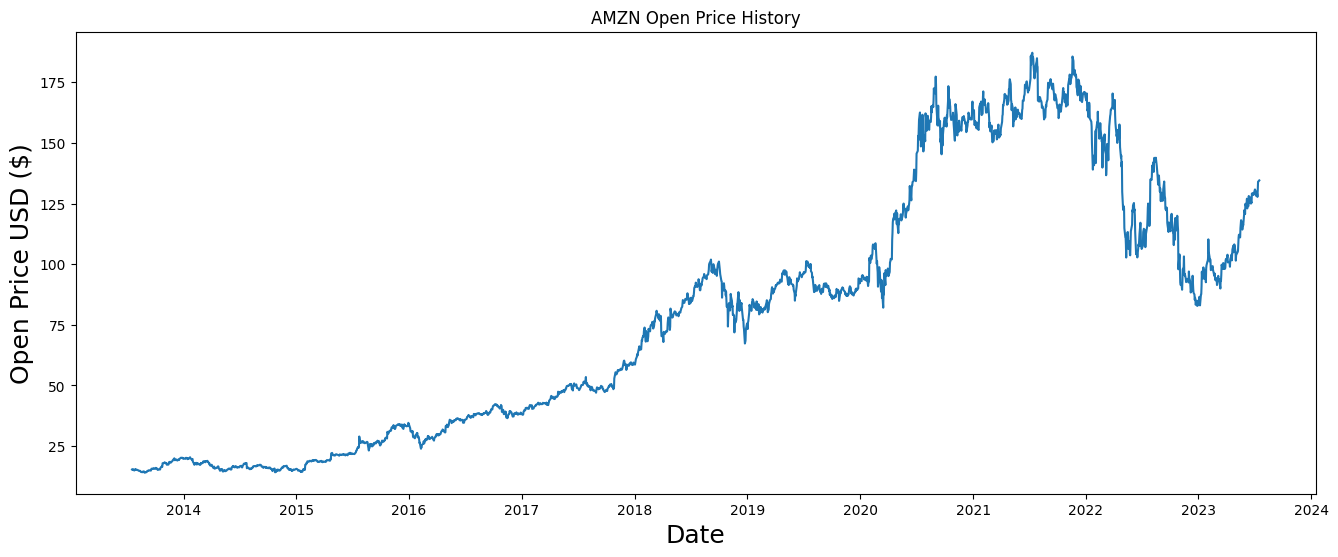

<ipython-input-3-79c8d0da0a5b>:48: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Company', 'Date'], dtype='object')
  amzn_df.rolling(100).mean()['Open'].plot()


<Axes: >

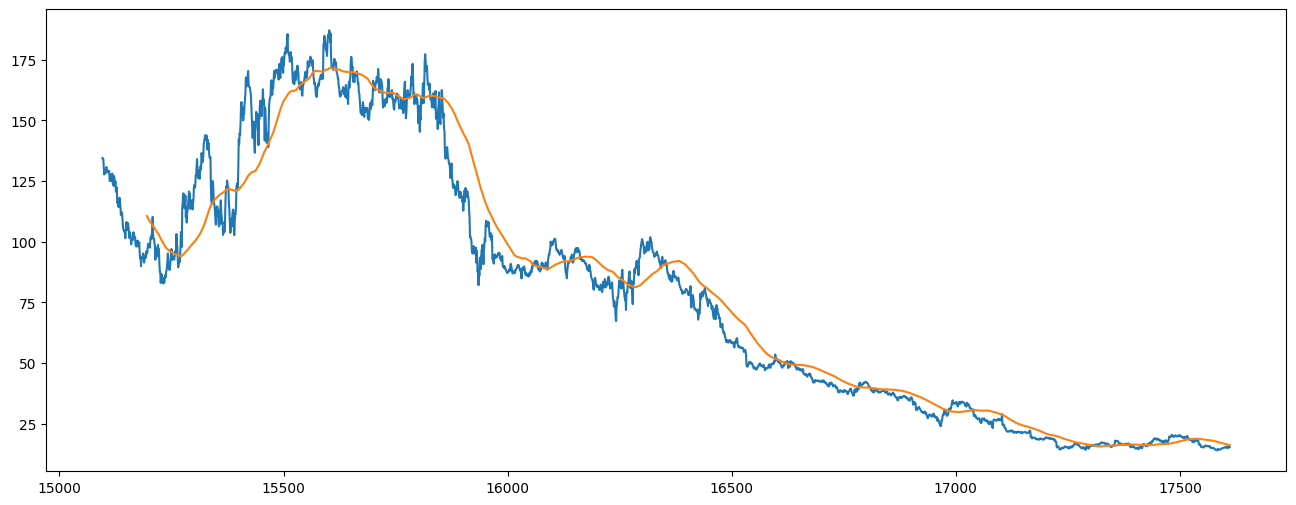

In [ ]:
# %%
# Import the modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras.layers import Dropout

# %%
# Read the csv file and clean the data
stock_data = pd.read_csv('Resources/data.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
price_columns = ['Close/Last', 'Open', 'High', 'Low']
for column in price_columns:
    stock_data[column] = stock_data[column].str.replace('$', '').astype(float)
amzn_data = stock_data[stock_data['Company'] == 'AMZN']
amzn_data = amzn_data.sort_values(by="Date")
amzn_data.head()

# %%
# Plotting the close price history
plt.figure(figsize=(16,6))
plt.title('AMZN Open Price History')
plt.plot(amzn_data['Date'], amzn_data['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# %%
amzn_data.isna().any()

# %%
amzn_data.tail(10)

# %%
# Split training and testing datasets

df_test = amzn_data.tail(40)
amzn_df = amzn_data.iloc[::-1]

# %%
# Moving average

amzn_df['Open'].plot(figsize=(16, 6))
amzn_df.rolling(100).mean()['Open'].plot()

Epoch 1/100
76/76 [==============================] - 19s 134ms/step - loss: 0.0178
Epoch 2/100
76/76 [==============================] - 9s 118ms/step - loss: 0.0040
Epoch 3/100
76/76 [==============================] - 10s 134ms/step - loss: 0.0033
Epoch 4/100
76/76 [==============================] - 10s 131ms/step - loss: 0.0033
Epoch 5/100
76/76 [==============================] - 10s 133ms/step - loss: 0.0029
Epoch 6/100
76/76 [==============================] - 9s 118ms/step - loss: 0.0031
Epoch 7/100
76/76 [==============================] - 10s 133ms/step - loss: 0.0027
Epoch 8/100
76/76 [==============================] - 11s 141ms/step - loss: 0.0033
Epoch 9/100
76/76 [==============================] - 10s 133ms/step - loss: 0.0027
Epoch 10/100
76/76 [==============================] - 11s 148ms/step - loss: 0.0027
Epoch 11/100
76/76 [==============================] - 9s 118ms/step - loss: 0.0026
Epoch 12/100
76/76 [==============================] - 10s 134ms/step - loss: 0.0025
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 [==============================] - 2s 22ms/step


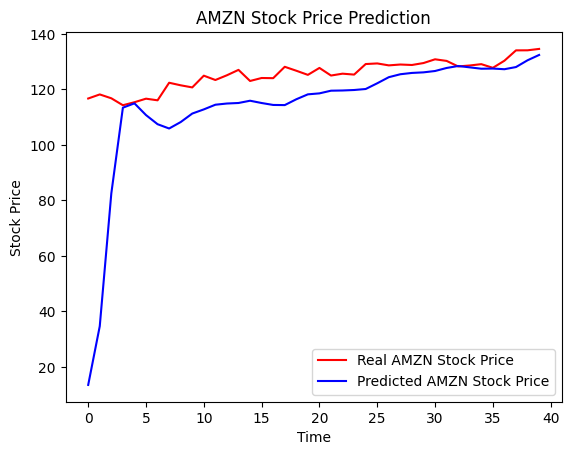

In [ ]:
training_df = amzn_df['Open']
training_df = pd.DataFrame(training_df)
training_df

# %%
# Feature scaling

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_df_scaled = sc.fit_transform(training_df)

# %%
# Create structure with 60 timesteps and 1 output

X_train = []
y_train = []
for i in range(60, 2476):
    X_train.append(training_df_scaled[i-60:i, 0])
    y_train.append(training_df_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)



# Reshape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train


# %%
# Initialize RNN

regressor = Sequential()

# %%
# First LSTM layer

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))


# Second LSTM layer

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


# Third LSTM layer

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


# Fourth LSTM layer

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))


# Output layer

regressor.add(Dense(units = 1))

# %%
# Compile RNN

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fit RNN

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

# %%
real_stock_price = df_test['Open'].values
real_stock_price

# %%
df_total = pd.concat((amzn_df['Open'], df_test['Open']), axis = 0)
inputs = df_total[len(df_total) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 100):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# %%
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.values
predicted_stock_price

# %%
real_stock_price

# %%
# Plot the results

plt.plot(real_stock_price, color = 'red', label = 'Real AMZN Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# New Section